# 2D Alignment - Maximum CC vs. Maximum-Likelihood

In [1]:
from scipy import ndimage
import scipy; import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

## Import test image

In [2]:
pig_raw = ndimage.imread('1_animal-1296764_960_720.png').mean(-1)
pig_bw = scipy.misc.imresize(pig_raw, (200,200)) 
pig = np.pad(pig_bw, 25, mode='constant') 
pig = (pig - pig.min()); pig = pig/pig.max()

Text(0.5,1,'Test Image - Little Piggy')

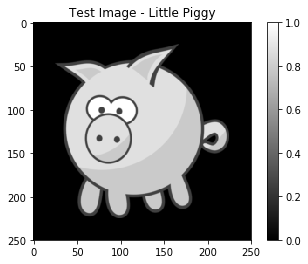

In [3]:
plt.imshow(pig, cmap='gray'); plt.colorbar()
plt.title('Test Image - Little Piggy')

## Image formation model

Images are assumed to follow the data model:

$$X_i = A + \sigma G_i$$
where $X_i$ is the i'th image, $A$ the underlying 2D image and $G_i$ a Gaussian noise term.

In [4]:
def noisify(image, sigma=1):
    return image + sigma * np.random.randn(*image.shape)
def rotate(image, angle=0):
    return ndimage.interpolation.rotate(image, angle, reshape=False)

## Binning

In [5]:
binning = 1
pig = pig[::binning,::binning]

## Generation of Reference Structure

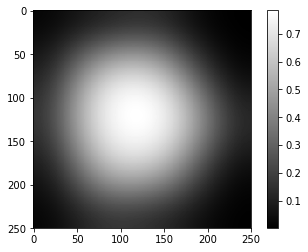

In [182]:
reference = ndimage.filters.gaussian_filter(pig, 2*pig.shape[0]//15)
plt.imshow(reference, cmap='gray'); plt.colorbar()

## Generation of Rotated Stack

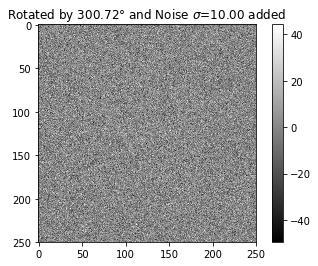

In [183]:
N = 500; sigma = 10
images_stack = []
angles = np.random.uniform(0,360,N)
for angle in angles:
    pig_rotated = rotate(pig, angle)
    pig_noisy = noisify(pig_rotated, sigma)
    images_stack.append(pig_noisy)
images_stack = np.array(images_stack)

plt.imshow(images_stack[0], cmap='gray')
plt.title('Rotated by %.2f° and Noise $\sigma$=%.2f added'%(angles[0],sigma))
plt.colorbar()

## Generate Rotated average images

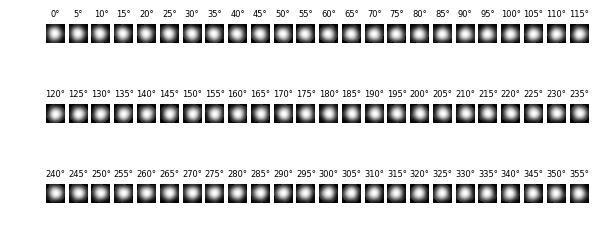

In [184]:
def rotate_reference(reference, n):
    angles = np.linspace(0,360,n,endpoint=False)
    reference_stack = []
    for angle in angles:
        reference_stack.append(rotate(reference,angle))
    return angles, np.array(reference_stack)

angular_sampling = 36*2
angles_reference, reference_stack = rotate_reference(reference, angular_sampling)
fig, axes = plt.subplots(3,angular_sampling//3, dpi=100, figsize=(7,3))
for angle,ax,ref in zip(angles_reference,axes.flatten(),reference_stack):
    ax.imshow(ref, cmap='gray')
    ax.set_title('%.0f°'%angle, fontsize=6); ax.axis('off')

## Maximum CC / Least Squares

Squared difference between observed data $X_i$ and reference $A$

$$\sum_{i=1}^N{\Vert X_i - R_{\phi i} A \Vert}^2 $$
$$= \sum_{i=1}^N{\Vert X_i \Vert^2} + \sum_{i=1}^N{ \Vert R_{\phi i} A \Vert^2} - 2\sum_{i=1}^N{X_i R_{\phi i} A}$$

Similar to CC

$$ CC =\frac{\sum_{i=1}^N{X_i R_{\phi i} A} }{N} $$

Text(0,0.5,'Correlation')

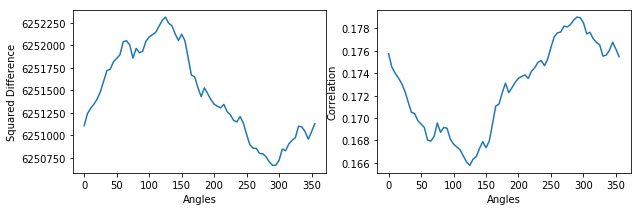

In [185]:
def sum_of_squared_difference(image, reference_stack):
    return ((image-reference_stack)**2).sum((1,2))
def correlation(image, reference_stack):
    return (image*reference_stack).mean((1,2))
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(10,3))
ax1.plot(angles_reference, sum_of_squared_difference(images_stack[0], reference_stack))
ax1.set_xlabel('Angles'); ax1.set_ylabel('Squared Difference')
ax2.plot(angles_reference, correlation(images_stack[0], reference_stack))
ax2.set_xlabel('Angles'); ax2.set_ylabel('Correlation')

In [186]:
angles_max_cc = []
for image in images_stack:
    correlation_all_angles = correlation(image, reference_stack)
    angles_max_cc.append(angles_reference[correlation_all_angles.argmax()])

Text(0.5,1,'Reconstruction from 500 noisy images')

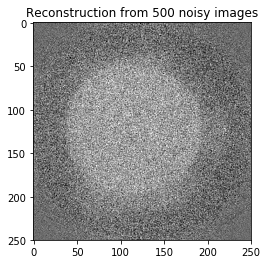

In [187]:
reconstruction = np.zeros_like(reference)
for angle_max_cc, image  in zip(angles_max_cc, images_stack):
    image_rotated = rotate(image, -angle_max_cc)
    reconstruction+= image_rotated
reconstruction /= len(images_stack)
reference = reconstruction
plt.imshow(reconstruction, cmap='gray')
plt.title('Reconstruction from %s noisy images'%N)

Text(0,0.5,'Max_CC angles')

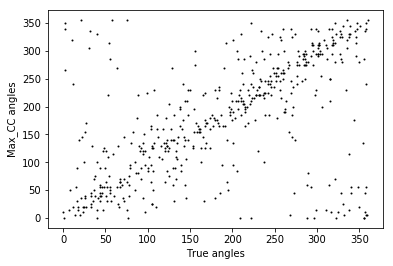

In [188]:
plt.scatter(angles, angles_max_cc, s=1, c='k')
plt.xlabel('True angles'); plt.ylabel('Max_CC angles')

Even with high noise level, the angles are detected quite reliably. Yet there are outliers here which contribute to errors in the final map. A statistical framework where a probablility weighted average is generated as an updated model will likely improve the result.

## Maximum Likelihood Method

We assume in this simplified case, that the noise level $\sigma$ is known.

In [189]:
print('Noise level is %s.'%sigma)

Noise level is 10.


In [190]:
def log_likelihood(image, model, sigma):
    z_score = (image-model).flatten()/sigma
    log_likelihood = np.log(scipy.stats.norm.pdf(z_score)).sum()
    return log_likelihood

Text(0,0.5,'Likelihood')

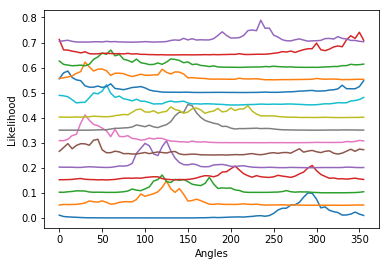

In [191]:
for i,image in enumerate(images_stack[0:15]):
    a = np.array([log_likelihood(image, reference, sigma) for reference in reference_stack])
    probs = np.exp(a-a.max())
    probs /= probs.sum()
    plt.plot(angles_reference, probs+i*0.05)
plt.xlabel('Angles'); plt.ylabel('Likelihood')

In [192]:
np.cumsum(np.sort(probs)[::-1])

array([ 0.08886676,  0.14629672,  0.2030477 ,  0.25316467,  0.30065792,
        0.3478134 ,  0.39053803,  0.41992037,  0.44844093,  0.47651392,
        0.50444716,  0.52796787,  0.549807  ,  0.56933308,  0.58732259,
        0.60531182,  0.62205675,  0.63842677,  0.65463032,  0.67022595,
        0.68547146,  0.70055205,  0.71505858,  0.72917458,  0.74305608,
        0.7543598 ,  0.76530509,  0.77624136,  0.78667717,  0.79703897,
        0.80735569,  0.81763778,  0.82760568,  0.8373083 ,  0.84635023,
        0.85504611,  0.86359608,  0.87199373,  0.88024049,  0.8884509 ,
        0.89555387,  0.90240744,  0.90922304,  0.91595696,  0.92263805,
        0.92794377,  0.93273996,  0.93735618,  0.94192313,  0.94641261,
        0.9503182 ,  0.95406005,  0.95757288,  0.96077538,  0.96381538,
        0.96677259,  0.96968927,  0.97234617,  0.97494494,  0.9772993 ,
        0.979532  ,  0.98171419,  0.98389178,  0.98601461,  0.98808242,
        0.9900776 ,  0.99196992,  0.99378408,  0.99555082,  0.99